In [5]:
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *
data_dict = load_data(verbose=True)

CONTENTS OF HDF5 FILE:
pose
	 ekf_ori, tango_ori, tango_pos
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce, game_rv, grav, gyro, gyro_uncalib, linacce, magnet, rv, time


In [6]:
w = data_dict['synced/gyro']
# 100 time steps
q_gt = data_dict['pose/tango_ori'][:100]
dt = data_dict['synced/time'][1] - data_dict['synced/time'][0]
q_pred = np.zeros((100,4))
q_pred[0] = q_gt[0]
factor= .0025                                # has been set arbitrarily
for i in range(1,100):
    q_pred[i] = Theta(w[i]*factor, dt=dt)@q_pred[i-1]



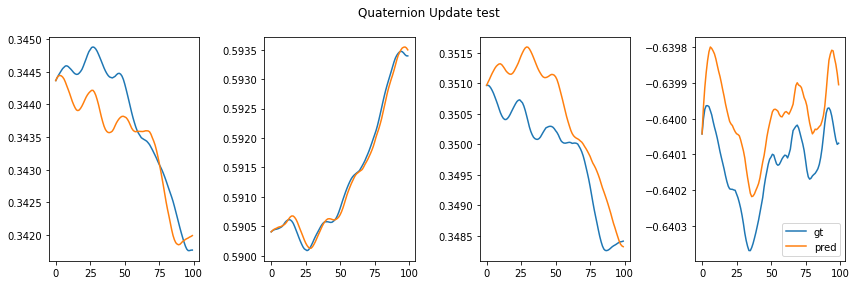

In [7]:
# plot
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].plot(q_gt[:,0],)
ax[0].plot(q_pred[:,0],)
ax[1].plot(q_gt[:,1],)
ax[1].plot(q_pred[:,1],)
ax[2].plot(q_gt[:,2],)
ax[2].plot(q_pred[:,2],)
ax[3].plot(q_gt[:,3],label='gt')
ax[3].plot(q_pred[:,3],label='pred')
ax[3].legend()
fig.suptitle('Quaternion Update test')
plt.tight_layout()

## NN

In [197]:
# set up a neural network with 3 inputs and 16 outputs
# the 3 inputs are the 3 components of the angular velocity
# the 16 outputs are the 16 elements of the 4x4 matrix Theta(w)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_size=3, output_size=16, hidden_size=16, num_layers=2):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.fc_input = nn.Linear(input_size, hidden_size)
        hidden_layers = []
        for i in range(self.num_layers):
            hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.hidden_layers = nn.ModuleList(hidden_layers)

        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #print(x)
        x = F.relu(self.fc_input(x))
        for i in range(self.num_layers):
            x = F.relu(self.hidden_layers[i](x))
            
        x = self.fc_output(x)
        return x
    
net = Net(input_size=3, output_size=16, hidden_size=64, num_layers=16)
print(net)

# number of params
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

Net(
  (fc_input): Linear(in_features=3, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-15): 16 x Linear(in_features=64, out_features=64, bias=True)
  )
  (fc_output): Linear(in_features=64, out_features=16, bias=True)
)


In [198]:
# prep the data
train_size = 500
w = data_dict['synced/gyro'][:train_size]        # inputs
q_gt = data_dict['pose/tango_ori'][:train_size]  # ground truth

test_size = 100
w_test = data_dict['synced/gyro'][train_size:train_size+test_size]        # inputs
q_gt_test = data_dict['pose/tango_ori'][train_size:train_size+test_size]  # ground truth

# dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, w, q_gt, ):
        self.w = torch.tensor(w[1:], dtype=torch.float32)
        self.q_gt = torch.tensor(q_gt[1:], dtype=torch.float32)
        self.q_gt_prev = torch.tensor(np.roll(q_gt, 1, axis=0)[1:], dtype=torch.float32)
        
    def __len__(self):
        return len(self.w)

    def __getitem__(self, idx):
        w = self.w[idx]
        q_gt = self.q_gt[idx]
        q_gt_prev = self.q_gt_prev[idx]
        return w, q_gt, q_gt_prev
    
dataset = MyDataset(w, q_gt)
dataset_test = MyDataset(w_test, q_gt_test)

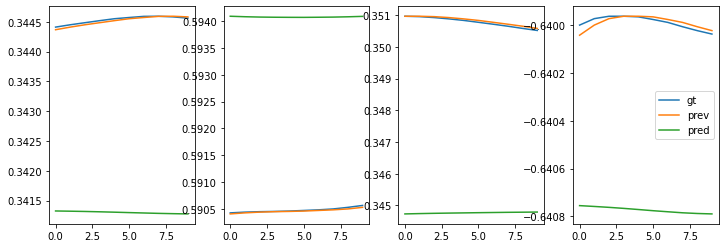

In [204]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
q_gt_from_dataset = np.array([dataset[i][1].detach().numpy() for i in range(10)])
q_prev_from_dataset = np.array([dataset[i][2].detach().numpy() for i in range(10)])
pred = np.array([net(dataset[0][0]).detach().numpy().reshape(4,4)@dataset[i][2].detach().numpy() for i in range(10)])

for i in range(4):
    ax[i].plot(#np.arange(1,len(q_gt_from_dataset)+1), 
               q_gt_from_dataset[:,i], label='gt')
    ax[i].plot(q_prev_from_dataset[:,i], label='prev')
    ax[i].plot(pred[:,i], label='pred')
ax[i].legend()



In [200]:
# set up the optimizer
lr = 0.00001
optimizer = optim.SGD(net.parameters(), lr=lr)

In [203]:


# set up the loss function
def quat_estimation_loss(theta, y_gt, y_gt_prev):
    """
    theta is the flattened 4x4 matrix which we are trying to predict
    y_gt is the ground truth quaternion
    y_gt_prev is the previous ground truth quaternion
    """
    theta = theta.reshape(4,4)
    pred = theta@y_gt_prev
    #print(pred.shape)
    #print(y_gt.shape)
    # assert norm(pred) == 1    
    # MSE
    return ((y_gt - pred).abs()).sum()*1000

# set up the training loop
num_epochs = 50
print('learning rate: ', lr)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataset):
        # get the inputs; data is a list of [inputs, labels]
        w_, q_gt_, q_gt_prev_ = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        theta = net(w_)
        #print(theta)
        loss = quat_estimation_loss(theta, q_gt_, q_gt_prev_)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    
    
    # every 5 epochs halve the learning rate
    how_often = 5
    if epoch % how_often == how_often-1:
        lr = lr/2
        print('learning rate: ', lr)
        optimizer = optim.SGD(net.parameters(), lr=lr)
        print(f'epoch {epoch} loss: {running_loss/len(dataset)}')

learning rate:  9.765625e-09
learning rate:  4.8828125e-09
epoch 4 loss: 4.209980032964794
learning rate:  2.44140625e-09
epoch 9 loss: 4.534196349566351
learning rate:  1.220703125e-09
epoch 14 loss: 4.638006733987996
learning rate:  6.103515625e-10
epoch 19 loss: 4.66401883213219
learning rate:  3.0517578125e-10
epoch 24 loss: 4.666994473738279
learning rate:  1.52587890625e-10
epoch 29 loss: 4.666304129159045
learning rate:  7.62939453125e-11
epoch 34 loss: 4.665314668643928
learning rate:  3.814697265625e-11
epoch 39 loss: 4.664931782739674
learning rate:  1.9073486328125e-11
epoch 44 loss: 4.664544592400591
learning rate:  9.5367431640625e-12
epoch 49 loss: 4.664333639259568


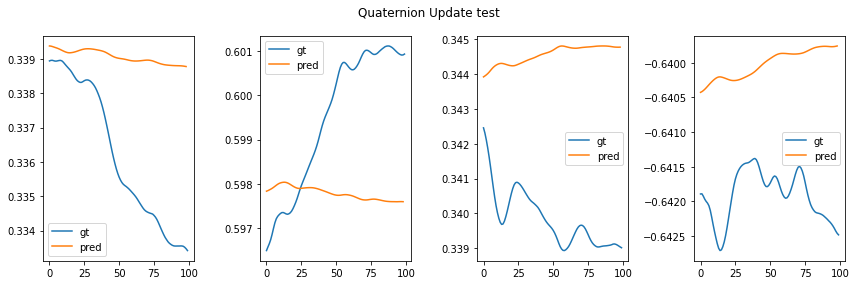

In [174]:
# evaluate the network
# testing on test set
with torch.no_grad():
    q_preds = []
    for i, data in enumerate(dataset_test):
        w_, q_gt_,q_gt_prev_ = data
        theta = net(w_)
        theta = theta.reshape(4,4)
        pred = theta@q_gt_prev_
        q_preds.append(pred.numpy())
    q_preds = np.array(q_preds)

# plot
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    ax[i].plot(q_gt_test[:,i],label='gt')
    ax[i].plot(q_preds[:,i],label='pred')
    ax[i].legend()
fig.suptitle('Quaternion Update test')
plt.tight_layout()

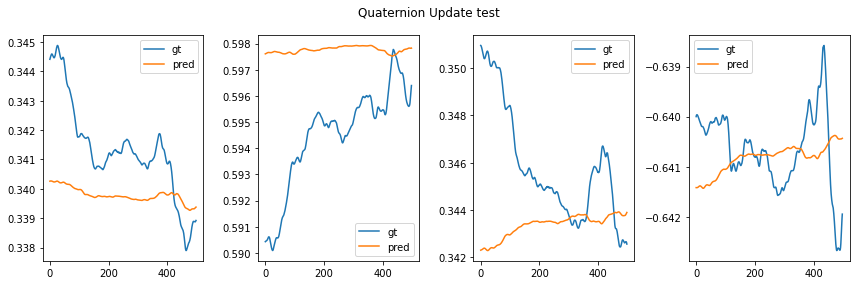

In [183]:
# testing on training data
with torch.no_grad():
    q_preds = []
    q_truth = []
    for i, data in enumerate(dataset):
        w_, q_gt_,_ = data
        
        q_truth.append(q_gt_.numpy())
        theta = net(w_)
        theta = theta.reshape(4,4)
        pred = theta@q_truth[i]
        q_preds.append(pred.numpy())

    q_preds = np.array(q_preds)
    q_truth = np.array(q_truth)

# plot
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    ax[i].plot(q_truth[:,i],label='gt')
    ax[i].plot(q_preds[:,i],label='pred')
    ax[i].legend()
fig.suptitle('Quaternion Update test')
plt.tight_layout()

In [ ]:
# so i think we might have a problem due to the fact that we have limit precision and  we are sampling very often. So the angular velocity doesnt have time to change the quaternion below the precision limit. As such we could try to only compare every 10 samples or so.